In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import *

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!

In [7]:
%%time
from direct_partition_functions import binder_parrallel
from time import time
n_cumulants = 5
T = np.linspace(1.5, 4, 20)
beta = 1/T
Ns = [8,12,14,16,18,20]
Us = [10,]
Js = [10,]
t = 1
alpha = 1.5
binder_params = dict(t = t, alpha = alpha, mu = 0, beta = None, J = None, U = None, normalise = True)

binder_cumulants = np.ones(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 2) as pool:
    for slice1, J in zip(binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                t0 = time()
                result = np.array([binder_parrallel(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t, alpha = alpha, pool=pool) for b in beta])
                np.copyto(slice3, np.einsum('ijk->jki',result))
                print(system_size, U, J, f'in {time() - t0:.0f} seconds')

np.savez('./pickled_data/binder_cumulants_direct_zoom.npz', 
         T=T, Ns=Ns, Us=Us, Js = Js, n_cumulants=n_cumulants, t=t, alpha = alpha, beta = beta,
         binder_cumulants=binder_cumulants)
print('done')

8 10 10 in 0 seconds
12 10 10 in 4 seconds
14 10 10 in 15 seconds
16 10 10 in 62 seconds
18 10 10 in 258 seconds
20 10 10 in 1463 seconds
done
CPU times: user 17min 28s, sys: 1min 17s, total: 18min 46s
Wall time: 30min 3s


In [23]:
#%%time
from time import time
from montecarlo import *
N_steps = int(100 * 1000)
N_burn_in = int(1 * 1000)

MCMC_params = dict(
        N_steps = N_steps, N_burn_in = N_burn_in, 
        state=np.arange(system_size)%2, 
        logger = Magnetisation_cumulants(N_cumulants = n_cumulants),
        proposal = p_multi_site_uniform_reflect,
        #proposal_args = dict(lam = 4),
        accept_function = simple_accept,
    )

T = np.linspace(1.5, 4, 15)
Ns = [8,12,14,16,18,20,40,80,160]
beta = 1/T

def compute(beta, **kwargs):
    kwargs['parameters']['beta'] = beta
    return FK_mcmc_2(**kwargs)


mcmc_binder_cumulants = np.zeros(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 2) as pool:
    for slice1, J in zip(mcmc_binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                t0 = time()
                binder_params.update(J=J, U=U)
                
                curried = functools.partial(compute, parameters = binder_params, **MCMC_params)
                
                result = pool.map(curried, beta)
                #(beta, [non_central/central], powers) -> ([non_central/central], powers, beta)
                np.copyto(slice3, np.einsum('ijk->jki',result))
                print(U, J, system_size, f'{time() - t0:.0f} seconds')

np.savez('./pickled_data/binder_cumulants_mcmc_zoom_4.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in, mc_beta=beta, mcmc_Ns = Ns,
         mcmc_binder_cumulants = mcmc_binder_cumulants)
print('done!')

Warning, p_acc = 0.05058762376237624, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.5957446808510638, 'J': 10, 'U': 10, 'normalise': True, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.050331683168316835, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.6666666666666666, 'J': 10, 'U': 10, 'normalise': True, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.05109108910891089, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.5384615384615384, 'J': 10, 'U': 10, 'normalise': True, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.0533559405940594, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.45161290322580644, 'J': 10, 'U': 10, 'normalise': True, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.051955940594059405, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.4912280701754386, 'J': 10, 'U': 10, 'normalise': True, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 0.054975247524752476, {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.417910447761194, 'J': 10, 'U': 10, 'normalise': True

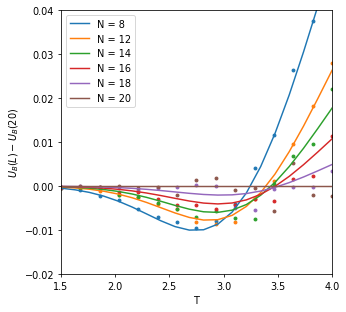

In [44]:
#%%time
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_zoom_huge.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc_zoom_3.npz')
locals().update(data)

def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

f, axes = plt.subplots(len(Js),len(Us),figsize = (5,5), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0), squeeze = False)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

largest_direct_bc =  binder_cumulant(binder_cumulants[0,0,-1,1])

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants, binder_cumulants, Js):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1, dir_slice1, Us):
        for i, dir_slice3, system_size in zip(count(), dir_slice2, Ns):
            #if system_size < 16: continue
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[i], = ax.plot(T, dir_binder_cumulant - largest_direct_bc, label = f'N = {system_size}')    

        for i, mc_slice3, system_size in zip(count(), mc_slice2, mcmc_Ns):
            #if system_size < 16: continue
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            ax.scatter(1/mc_beta, binder_cumulant(mc_Mf_central_moments) - np.interp(1/mc_beta, T, largest_direct_bc), marker='.',)
            
        ax.set(xlim = (1.5,4), ylim = (-0.02,0.04))
        ax.legend()

#f.suptitle('Binder Cumulant against Temperature')

#for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = r'$U_B(L) - U_B(20)$') 
for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./figs/binder_zoom.pdf')